# This script serves as a solution to a binary classification problem


## Contents
* Exploration data analysis 
    * [class imbalance and field types](#ci)
    * [Profiling Missing values and Class imbalance](#mb)
    * [Correlations between variables](#corr)
        
* Modeling
    * [Model selection](#ms)
    * [Model performance](#mp)
    * [model optimization](#mo)
    
    
* Executive summary
    * [Problem statement](#ps)
    * [Success evaluation](#sm)
    * [Model Explainer](#me)

* Pyspark implementation of the model
    * [Spark load](#sl)
    * [Pipeline design](#pd)
    * [Results](#R)
  

In [1]:
import pandas as pd

In [ ]:
0.1 , 0.2 , 0.3

In [483]:
dataset = pd.read_csv('assessment_data.csv')

In [5]:
dataset.head(10)

,target_var,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,1,211.3375,0,0,bigollo-16,blue,29.0000,1,sigma,112.877941
1,1,151.5500,2,1,cantor-33,pink,0.9167,1,sigma,60.291423
2,0,151.5500,2,1,cantor-33,blue,2.0000,1,sigma,143.794103
3,0,151.5500,2,1,cantor-33,pink,30.0000,1,sigma,131.278352
4,0,151.5500,2,1,cantor-33,blue,25.0000,1,sigma,204.415716
5,1,26.5500,0,0,euler-23,pink,48.0000,1,sigma,75.970582
6,1,77.9583,0,1,descrates-18,blue,63.0000,1,sigma,125.853521
7,0,0.0000,0,0,allen-47,pink,39.0000,1,sigma,103.637401
8,1,51.4792,0,2,cantor-112,blue,53.0000,1,sigma,94.425637
9,0,49.5042,0,0,NaN,pink,71.0000,1,gamma,85.687636


In [6]:
dataset.describe()

,target_var,feature_1,feature_2,feature_3,feature_6,feature_7,feature_9
count,1309.000000,1308.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000
mean,0.381971,33.295479,0.385027,0.498854,29.881135,2.294882,101.794120
std,0.486055,51.758668,0.865560,1.041658,14.413500,0.837836,50.890853
min,0.000000,0.000000,0.000000,0.000000,0.166700,1.000000,-93.974333
25%,0.000000,7.895800,0.000000,0.000000,21.000000,2.000000,68.550768
50%,0.000000,14.454200,0.000000,0.000000,28.000000,3.000000,102.039185
75%,1.000000,31.275000,0.000000,1.000000,39.000000,3.000000,135.175053
max,1.000000,512.329200,9.000000,8.000000,80.000000,3.000000,264.692290


## Class Imbalance <a id = "mb"></a>

Data are said to suffer the Class Imbalance Problem when the class distributions are highly imbalanced. 
In this context, classification learning algorithms may have low predictive accuracy for the infrequent class.

This dataset is not imbalanced and often small difference does not matter as shown below, and this does away with any need for resample techniques and generating synthetic samples.

In [162]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

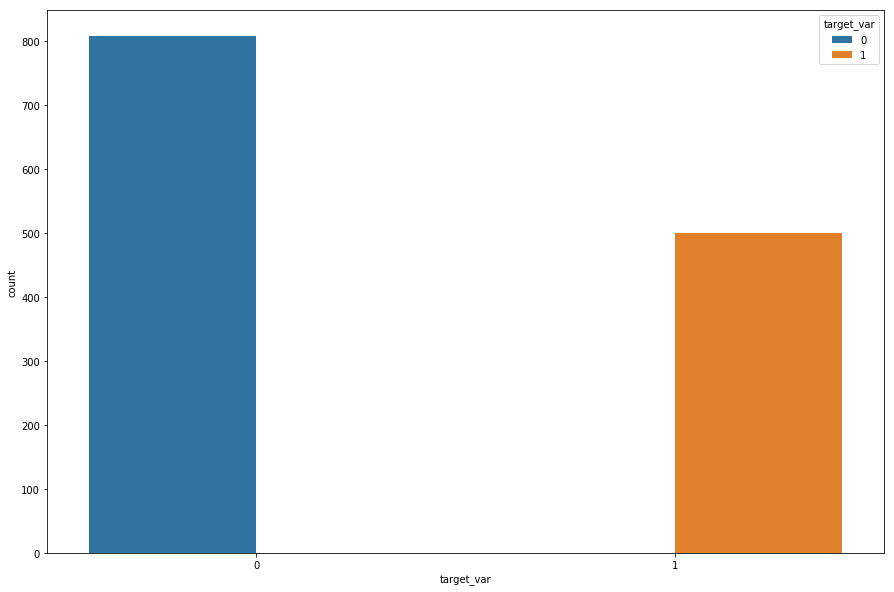

In [163]:
sns.countplot('target_var', data=dataset, hue = 'target_var')

# Data Profiling <a id = "cb"></a>
Pandas profiling is an open source Python module with which we can quickly do an exploratory data analysis with just a few lines of code. This can be presented in any format

In short, what pandas profiling does is save us all the work of visualizing and understanding the distribution of each variable. It generates a report with all the information easily available.

Things that I would have had to code as shown below can be executed in one condensed format :) saves so much time

In [9]:
print("Number of unique values in each field", '\n')
for i in dataset.columns:
    print(i, '  '  ,len(dataset[i].unique()) )

Number of unique values in each field 

target_var    2
feature_1    282
feature_2    8
feature_3    7
feature_4    182
feature_5    2
feature_6    99
feature_7    3
feature_8    4
feature_9    1309


In [25]:
import pandas_profiling

In [27]:
dataset.isna().sum()

target_var       0
feature_1        1
feature_2        0
feature_3        0
feature_4     1014
feature_5        0
feature_6      263
feature_7        0
feature_8        2
feature_9        0
dtype: int64

### Data profiling <a id = "corr"></a>
    - Features
    - Correlations
    - Missing values 
    - Samples

In [26]:
pandas_profiling.ProfileReport(dataset)

# Missing values <a id = "mb"></a>

We will drop columns that have more than 25-30% missing columns as common practice
or label fill them as "Unknown" incase the missing value means anything. 

In [10]:
dataset["feature_4"].fillna("Unknown", inplace = True)  
dataset["feature_1"].fillna(dataset.feature_1.mean(), inplace = True)  
dataset["feature_6"].fillna(dataset.feature_6.mean(), inplace = True)  
dataset['feature_8'].fillna('gamma', inplace = True) 

In [11]:
dataset.isna().sum()

target_var    0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
dtype: int64

In [12]:
import category_encoders as ce

In [426]:
encode = ['feature_4','feature_5','feature_8']
non_encode_features = ['feature_1', 'feature_2', 'feature_3', 'feature_6', 'feature_7', 'feature_9']
response = ['target_var']


In [427]:
ce_ord = ce.OrdinalEncoder(cols=encode)

In [428]:
encoded_data = ce_ord.fit_transform(dataset[encode],handle_missing='True' , handle_unknown='True' )

In [429]:
data = pd.concat([dataset[non_encode_features],encoded_data],axis=1)

# Model Selection <a id = "ms"></a>

In this section we try a selection of models with default parameters to see which one has better calibrated prediction probabilities, i.e given the prediction probabilities between 0 and 1 which model has a true positive rates in the bins which is approximately close to the mean predicted value. These are called reliability curves, testing if a model is reliable across the whole spectrum of prediction probabilities.

I also make use of TPOT. This is a package that folllows the scikit learn API one can use to explore model/pipeline configs.
This helps me with ideas on how to solve a machine learning problem by exploring pipeline configurations that I might have never considered, then leaves the fine-tuning to more constrained parameter tuning techniques such as grid search.

We see the gradient boosted algorithm outperforming all other algorithms.

In [18]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [463]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, Y_train, Y_test = train_test_split(data[encode+non_encode_features].values, dataset[response].values, test_size=.25)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Reliability Curves and TPOT(Automated ML tool)

C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the 

LogisticRegression()
	Accuracy: 0.768
	Precision: 0.685
	Recall: 0.650
	F1: 0.667

GaussianNB()
	Accuracy: 0.732
	Precision: 0.614
	Recall: 0.667
	F1: 0.639

LinearSVC()
	Accuracy: 0.771
	Precision: 0.691
	Recall: 0.650
	F1: 0.670



C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier()
	Accuracy: 0.765
	Precision: 0.667
	Recall: 0.684
	F1: 0.675



C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(20, 15, 10, 6), solver='sgd')
	Accuracy: 0.753
	Precision: 0.658
	Recall: 0.641
	F1: 0.649

GradientBoostingClassifier()
	Accuracy: 0.793
	Precision: 0.717
	Recall: 0.692
	F1: 0.704



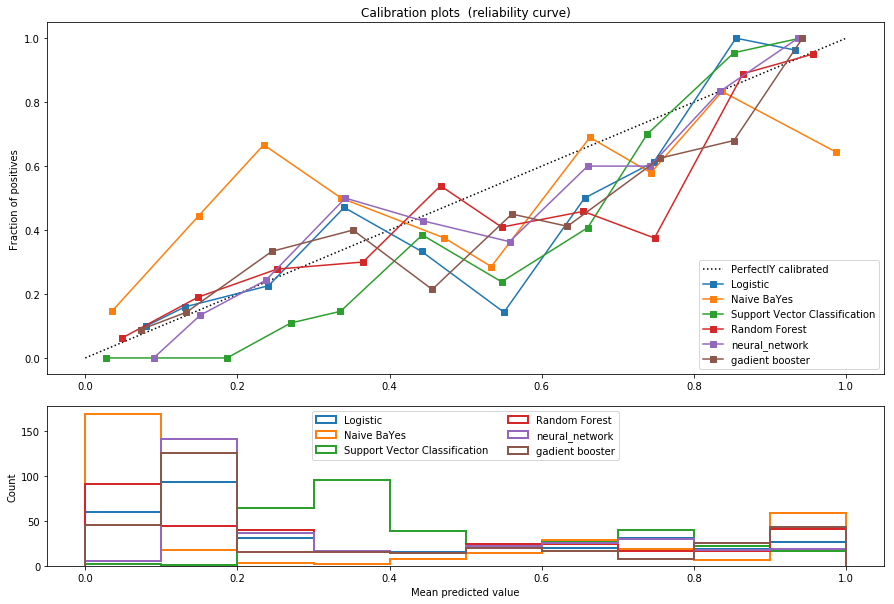

<Figure size 1440x720 with 0 Axes>

In [58]:
np.random.seed(0)
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)
mlp = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(20,15,10,6))
gbm = GradientBoostingClassifier()
plt.rcParams['figure.figsize'] = (15.0, 10.0)


# #############################################################################z
# Plot calibration plots

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="PerfectlY calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive BaYes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (mlp, 'neural_network'),
                 (gbm, 'gadient booster')]:
    clf.fit(X_train, Y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(Y_test, prob_pos, n_bins=10)
    pred =  clf.predict(X_test)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    print(clf)
    print("\tAccuracy: %1.3f"%clf.score(X_test, Y_test))
    print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
    print("\tRecall: %1.3f" % recall_score(Y_test, pred))
    print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.figure(figsize=(20,10))
plt.savefig('models.png')
plt.tight_layout()
plt.show()

In [27]:
from tpot import TPOTClassifier
from tpot.config import classifier_config_dict

tpot = TPOTClassifier(generations=10, population_size=100, verbosity=2)
tpot.fit(X_train, Y_train)
print(tpot.score(X_test, Y_test))
tpot.export('tpot_assignment_pipeline.py')

C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Generation 1 - Current best internal CV score: 0.8155081321868849
Generation 2 - Current best internal CV score: 0.8155081321868849
Generation 3 - Current best internal CV score: 0.8155081321868849
Generation 4 - Current best internal CV score: 0.8165130011395421
Generation 5 - Current best internal CV score: 0.8165130011395421
Generation 6 - Current best internal CV score: 0.8195690458924687
Generation 7 - Current best internal CV score: 0.8195690458924687
Generation 8 - Current best internal CV score: 0.8195690458924687
Generation 9 - Current best internal CV score: 0.8206049932663421
Generation 10 - Current best internal CV score: 0.822635450119134
Best pipeline: XGBClassifier(DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=3, min_samples_leaf=16, min_samples_split=12), learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.6500000000000001)
0.7835365853658537


C:\Users\tumisang2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Model Performace <a id = "mp"></a>

1. model evaluation: we may want to know how good is the model, i.e., how reliable are the model predictions (how frequent and how large errors we may expect)
2. model comparison: we may want to compare two or more models in order to choose between them;
3. out-of-sample and out-of-time comparisons: we may want to check model’s performance when applied to new data to evaluate if the performance has not worsened.

we first observe feature importance graph which can be important given how good a model is, with a bad model you would want to avoid feature importance graphs as they can be very misleading in terms of the models exlanatory power.

The scores are useful and can be used in a range of situations in a predictive modeling problem, such as:

1. Better understanding the data.
2. Better understanding a model.
3. Reducing the number of input features - like how  __feature_4__ seems to not be contributing much in making predictions. we have a low margin loss in the accuracy(2%), this is likey to even be lower with a good-fit model
   

In [464]:
xgb_clf = xgb.XGBClassifier( min_samples_leaf=16, min_samples_split=12, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.6500000000000001)
xgb_clf.fit(X_train,Y_train.ravel())



XGBClassifier(max_depth=4, min_child_weight=5, min_samples_leaf=16,
              min_samples_split=12, nthread=1, subsample=0.6500000000000001)

In [465]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

 
    plt.tight_layout()

In [460]:
from sklearn.metrics import confusion_matrix
import itertools

With feature_4
	Accuracy: 0.790
	Precision: 0.707
	Recall: 0.701
	F1: 0.704

Normalized confusion matrix


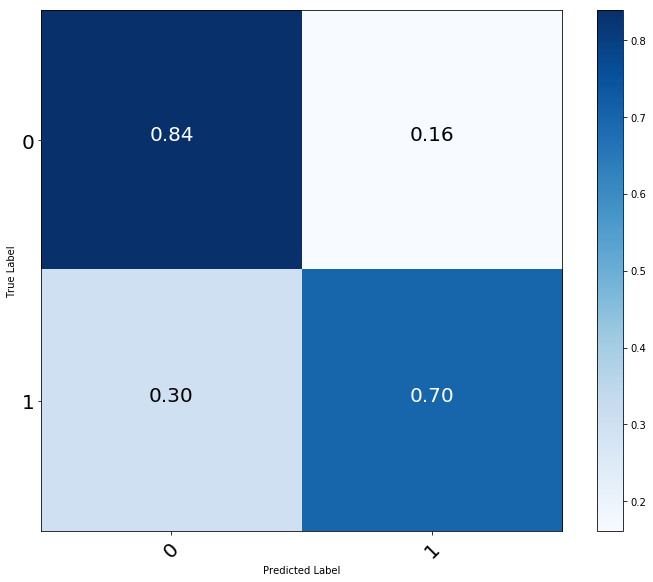

In [68]:
pred=xgb_clf.predict(X_test)
pred=pred.astype('int64')
cnf_matrix = confusion_matrix(Y_test, pred)
print("With feature_4")
print("\tAccuracy: %1.3f"%xgb_clf.score(X_test, Y_test))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

Without feature_4
	Accuracy: 0.774
	Precision: 0.700
	Recall: 0.689
	F1: 0.694

Normalized confusion matrix


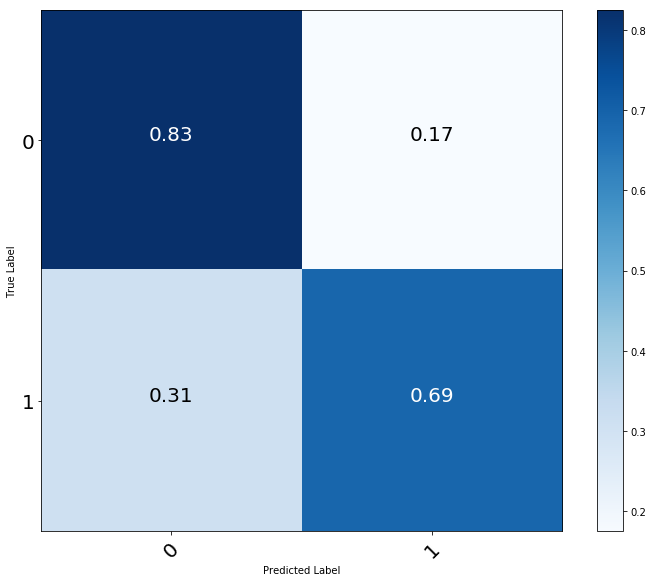

In [173]:
pred=xgb_clf.predict(X_test)
pred=pred.astype('int64')
cnf_matrix = confusion_matrix(Y_test, pred)
print("Without feature_4")
print("\tAccuracy: %1.3f"%xgb_clf.score(X_test, Y_test))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

In [189]:
from sklearn.model_selection import cross_val_score

X= data[non_encode_features+encode]
y= dataset[response].values.ravel()
scores = cross_val_score(xgb_clf, X, y, cv=10)

In [190]:
scores

array([0.70992366, 0.81679389, 0.81679389, 0.83969466, 0.81679389,
       0.75572519, 0.74045802, 0.64122137, 0.67175573, 0.70769231])

In [72]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.20)


In [191]:
from sklearn import metrics
scores = cross_val_score(clf, X, y, cv=10, scoring='f1_micro')
scores

array([0.53435115, 0.65648855, 0.67175573, 0.67175573, 0.58015267,
       0.64885496, 0.65648855, 0.64122137, 0.54961832, 0.62307692])

In [175]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro']

scores = cross_validate(xgb_clf, X, y, scoring=scoring)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_precision_macro',
 'test_recall_macro',
 'train_precision_macro',
 'train_recall_macro']

In [177]:
scores

{'fit_time': array([0.249, 0.272, 0.251]),
 'score_time': array([0.011, 0.013, 0.012]),
 'test_precision_macro': array([0.683, 0.468, 0.509]),
 'train_precision_macro': array([0.995, 0.994, 0.998]),
 'test_recall_macro': array([0.543, 0.476, 0.5  ]),
 'train_recall_macro': array([0.992, 0.994, 0.997])}

# Overcoming our overfitting problem <a id = "mo"></a>

Overfitting is a significant practical difficulty for decision tree models and many other predictive models. Overfitting happens when the learning algorithm continues to develop hypotheses that reduce training set error at the cost of an
increased test set error. This is evident in the model evaluated below.
This difiiculty can be overcome in a number of ways:
1. K-Fold Cross validation 
2. Early stopping during training
3. balancing the dataset
4. more data or increaing the test/train split 
5. etc...

[0]	validation_0-error:0.194983	validation_0-logloss:0.652039	validation_1-error:0.226852	validation_1-logloss:0.654096
[1]	validation_0-error:0.18358	validation_0-logloss:0.61741	validation_1-error:0.203704	validation_1-logloss:0.622772
[2]	validation_0-error:0.185861	validation_0-logloss:0.589876	validation_1-error:0.194444	validation_1-logloss:0.597121
[3]	validation_0-error:0.188141	validation_0-logloss:0.566416	validation_1-error:0.196759	validation_1-logloss:0.575726
[4]	validation_0-error:0.188141	validation_0-logloss:0.544382	validation_1-error:0.199074	validation_1-logloss:0.554482
[5]	validation_0-error:0.188141	validation_0-logloss:0.527908	validation_1-error:0.196759	validation_1-logloss:0.538763
[6]	validation_0-error:0.188141	validation_0-logloss:0.5127	validation_1-error:0.19213	validation_1-logloss:0.525214
[7]	validation_0-error:0.189282	validation_0-logloss:0.499883	validation_1-error:0.196759	validation_1-logloss:0.514226
[8]	validation_0-error:0.189282	validation_0-

[69]	validation_0-error:0.13455	validation_0-logloss:0.345815	validation_1-error:0.215278	validation_1-logloss:0.454321
[70]	validation_0-error:0.13797	validation_0-logloss:0.345421	validation_1-error:0.212963	validation_1-logloss:0.454478
[71]	validation_0-error:0.141391	validation_0-logloss:0.344493	validation_1-error:0.215278	validation_1-logloss:0.454222
[72]	validation_0-error:0.13683	validation_0-logloss:0.343331	validation_1-error:0.210648	validation_1-logloss:0.454783
[73]	validation_0-error:0.13683	validation_0-logloss:0.342067	validation_1-error:0.210648	validation_1-logloss:0.455018
[74]	validation_0-error:0.13569	validation_0-logloss:0.341202	validation_1-error:0.212963	validation_1-logloss:0.455629
[75]	validation_0-error:0.133409	validation_0-logloss:0.340116	validation_1-error:0.217593	validation_1-logloss:0.456279
[76]	validation_0-error:0.132269	validation_0-logloss:0.338578	validation_1-error:0.212963	validation_1-logloss:0.456503
[77]	validation_0-error:0.13455	valid

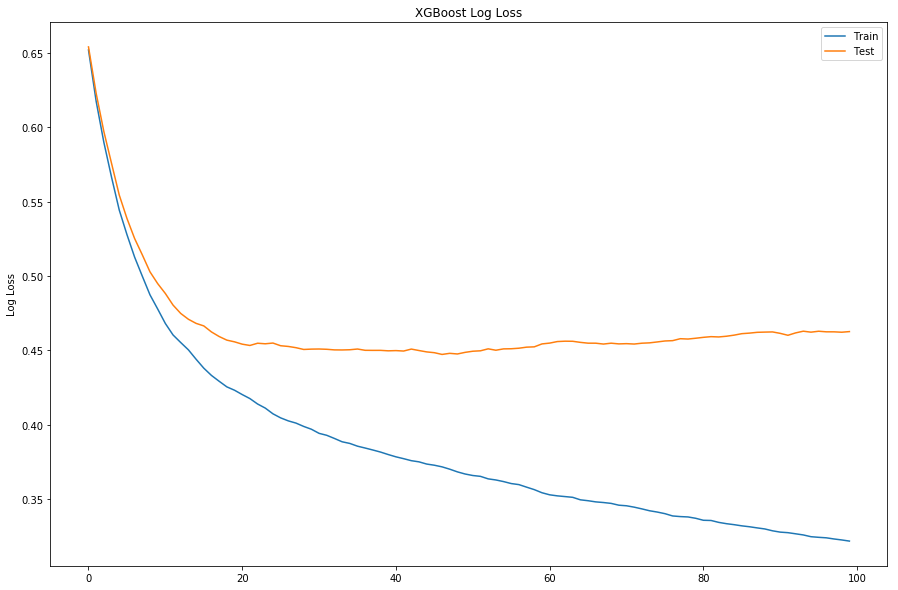

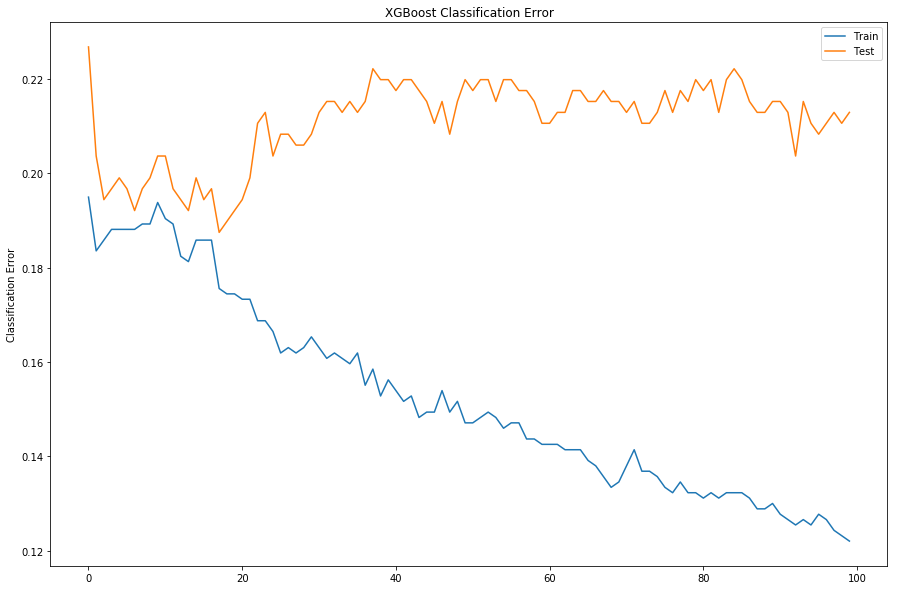

In [75]:


from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model no training data
model = xgb.XGBClassifier( learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.6500000000000001)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [471]:
X= data[non_encode_features+encode]
y= dataset[response]

dtrain = xgb.DMatrix(X, label=y)

In [472]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

param['eval_metric'] = ['auc', 'ams@0']


# evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [473]:
num_round = 10
bst = xgb.train(param, dtrain, num_round)
# After training, the model can be saved.
# bst.save_model('0001.model')


In [474]:
dtest = xgb.DMatrix(X)
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [475]:
pred=bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [451]:
len(pred) , len(X)

(1309, 1309)

In [476]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test,Y_test)

In [125]:
import os
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test,Y_test)
param = [('max_depth', 2), ('objective', 'binary:logistic'), ('eval_metric', 'logloss'), ('eval_metric', 'error'), ('learning_rate','0.1')]

num_round = 100
watchlist = [(dtest,'eval'), (dtrain,'train')]

evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result)

print('Access logloss metric directly from evals_result:')
print(evals_result['eval']['logloss'])

print('')
print('Access metrics through a loop:')
for e_name, e_mtrs in evals_result.items():
    print('- {}'.format(e_name))
    for e_mtr_name, e_mtr_vals in e_mtrs.items():
        print('   - {}'.format(e_mtr_name))
        print('      - {}'.format(e_mtr_vals))

print('')
print('Access complete dictionary:')
print(evals_result)

[0]	eval-logloss:0.653594	eval-error:0.189024	train-logloss:0.658074	train-error:0.219164
[1]	eval-logloss:0.618863	eval-error:0.185976	train-logloss:0.628693	train-error:0.221203
[2]	eval-logloss:0.58928	eval-error:0.185976	train-logloss:0.602634	train-error:0.221203
[3]	eval-logloss:0.563287	eval-error:0.185976	train-logloss:0.581066	train-error:0.221203
[4]	eval-logloss:0.544854	eval-error:0.185976	train-logloss:0.564895	train-error:0.221203
[5]	eval-logloss:0.525632	eval-error:0.185976	train-logloss:0.549278	train-error:0.221203
[6]	eval-logloss:0.511226	eval-error:0.185976	train-logloss:0.537532	train-error:0.222222
[7]	eval-logloss:0.497109	eval-error:0.185976	train-logloss:0.52558	train-error:0.221203
[8]	eval-logloss:0.486053	eval-error:0.185976	train-logloss:0.516996	train-error:0.222222
[9]	eval-logloss:0.476198	eval-error:0.185976	train-logloss:0.509466	train-error:0.222222
[10]	eval-logloss:0.469229	eval-error:0.189024	train-logloss:0.502802	train-error:0.22528
[11]	eval-lo

[91]	eval-logloss:0.405944	eval-error:0.179878	train-logloss:0.404874	train-error:0.171254
[92]	eval-logloss:0.40525	eval-error:0.176829	train-logloss:0.404108	train-error:0.169215
[93]	eval-logloss:0.405004	eval-error:0.176829	train-logloss:0.4037	train-error:0.171254
[94]	eval-logloss:0.403405	eval-error:0.179878	train-logloss:0.403304	train-error:0.172273
[95]	eval-logloss:0.404452	eval-error:0.176829	train-logloss:0.40281	train-error:0.172273
[96]	eval-logloss:0.40482	eval-error:0.17378	train-logloss:0.402498	train-error:0.172273
[97]	eval-logloss:0.405104	eval-error:0.176829	train-logloss:0.402138	train-error:0.175331
[98]	eval-logloss:0.405007	eval-error:0.179878	train-logloss:0.401533	train-error:0.171254
[99]	eval-logloss:0.405408	eval-error:0.176829	train-logloss:0.400996	train-error:0.172273
Access logloss metric directly from evals_result:
[0.653594, 0.618863, 0.58928, 0.563287, 0.544854, 0.525632, 0.511226, 0.497109, 0.486053, 0.476198, 0.469229, 0.461028, 0.454775, 0.45058

In [ ]:
# Below we use parameter congiguration to -

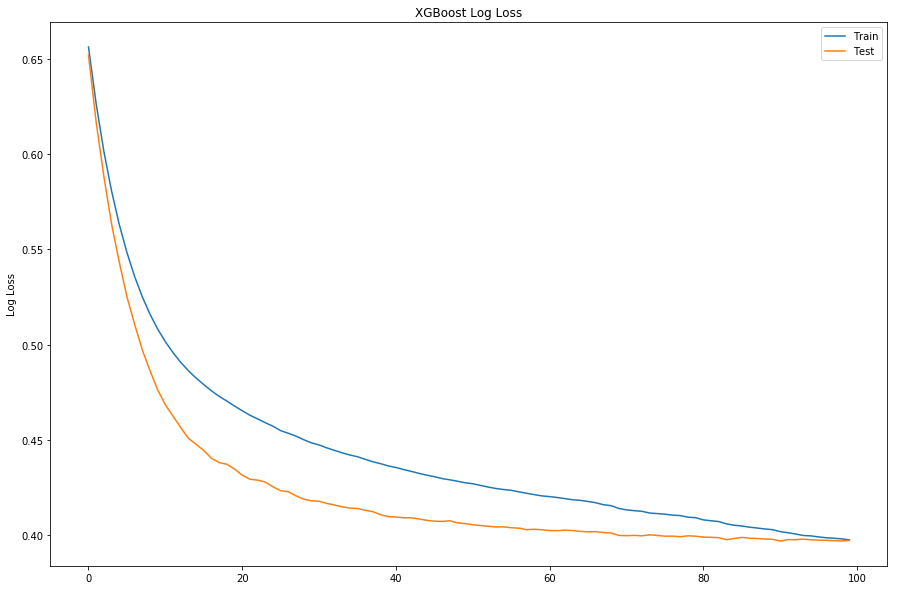

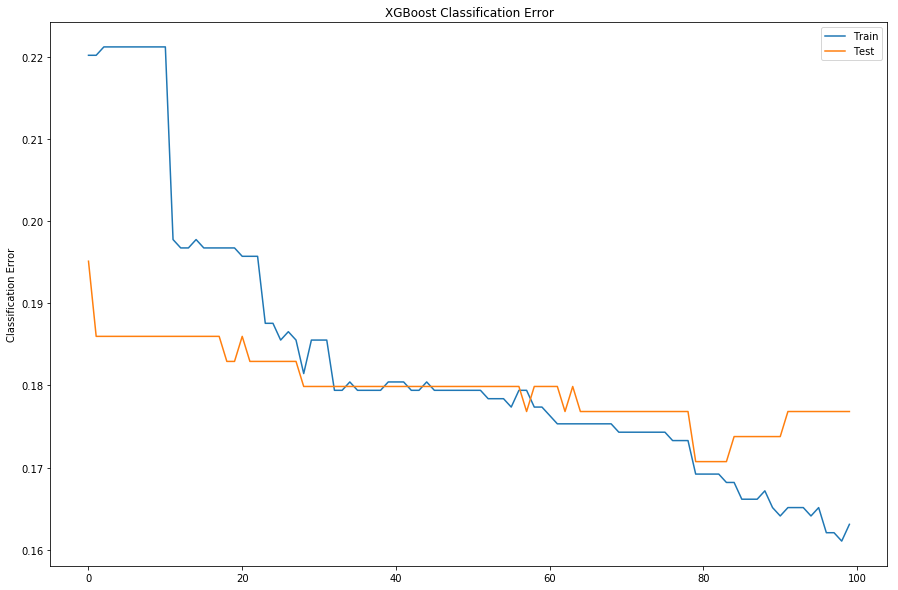

In [124]:
results = evals_result
epochs = len(results['eval']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['eval']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['train']['error'], label='Train')
ax.plot(x_axis, results['eval']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

# BEST XGBOOST MODEL 
    
    - Not overfit as the initial or non-optimized model
    - relatively good learning curves i.e Classification error and log-loss


I have not optimized for quite a number of things an

In [ ]:
import os
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test,Y_test)


param = [('criterion','gini'),('min_samples_leaf','16'),('min_samples_split','12'),('min_child_weight','5'),('n_estimators','100'),('nthread','1'),('subsample','0.6500000000000001'),('max_depth', 2), ('objective', 'binary:logistic'), ('eval_metric', 'logloss'), ('eval_metric', 'error'), ('learning_rate','0.1')]

num_round = 100
watchlist = [(dtest,'eval'), (dtrain,'train')]

evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result)

print('Access logloss metric directly from evals_result:')
print(evals_result['eval']['logloss'])

print('')
print('Access metrics through a loop:')
for e_name, e_mtrs in evals_result.items():
    print('- {}'.format(e_name))
    for e_mtr_name, e_mtr_vals in e_mtrs.items():
        print('   - {}'.format(e_mtr_name))
        print('      - {}'.format(e_mtr_vals))

print('')
print('Access complete dictionary:')
print(evals_result)

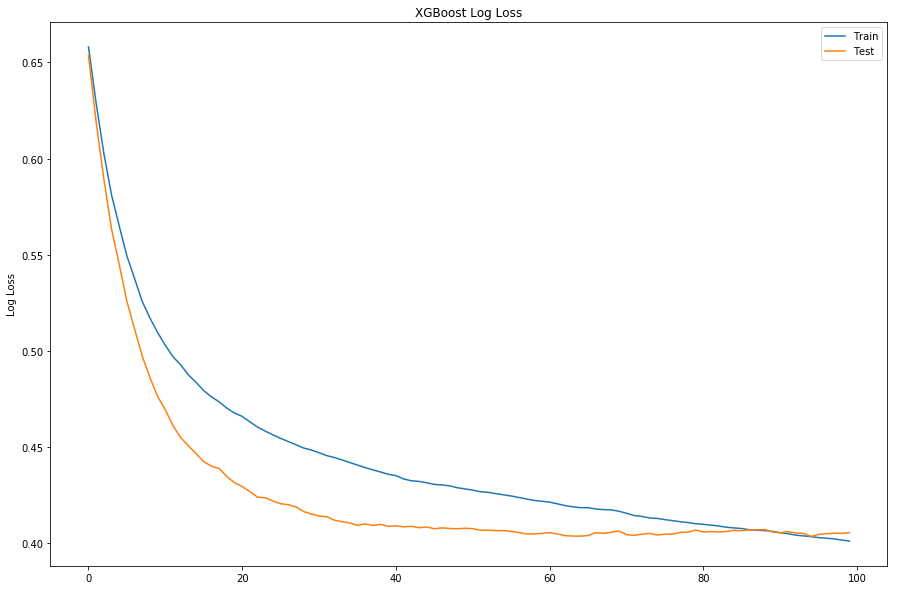

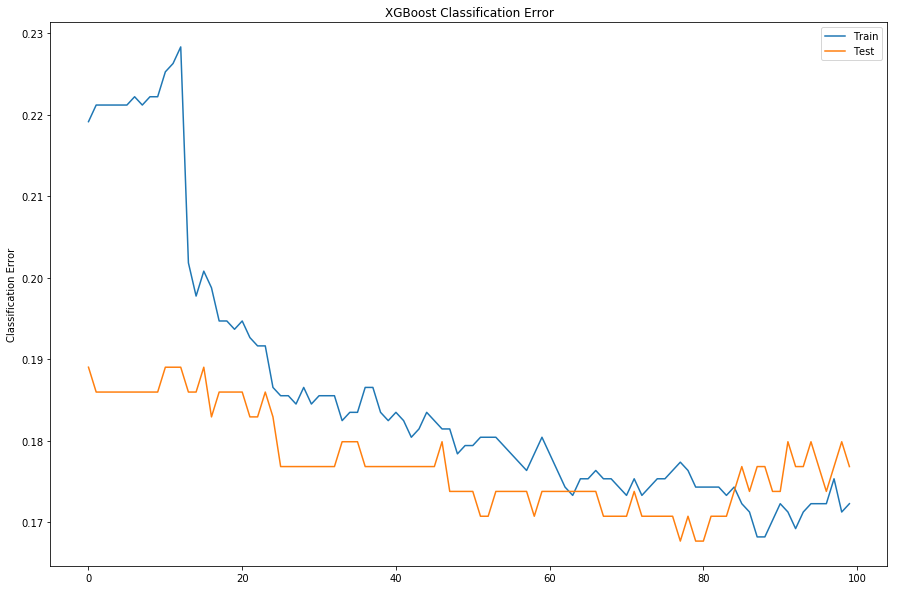

In [126]:
results = evals_result
epochs = len(results['eval']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['eval']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['train']['error'], label='Train')
ax.plot(x_axis, results['eval']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

could not determine class_counts_ from previously fitted classifier


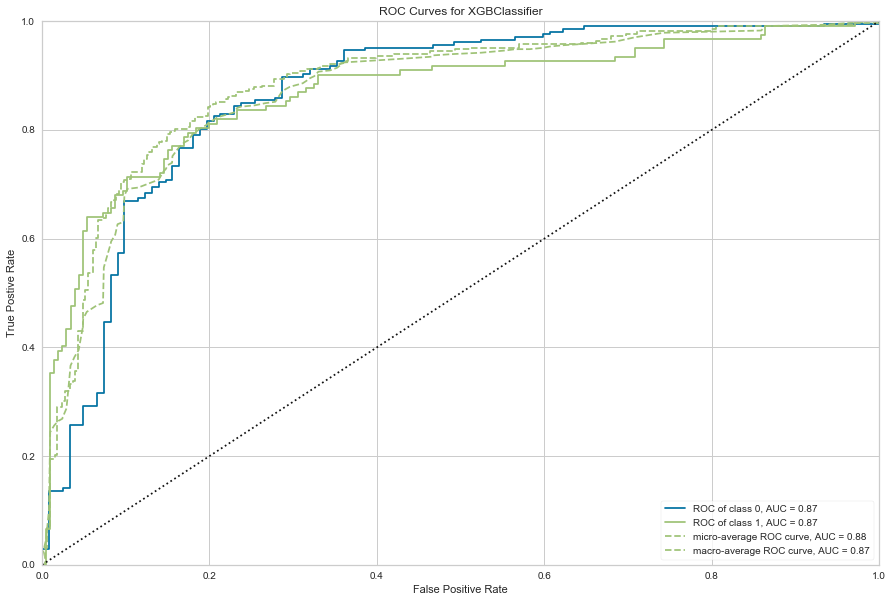

In [479]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

rocauc = ROCAUC(xgb_clf, size=(1080, 720), classes=['0','1'])

rocauc.score(X_test, Y_test)  
r = rocauc.poof()

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
could not determine class_counts_ from previously fitted classifier


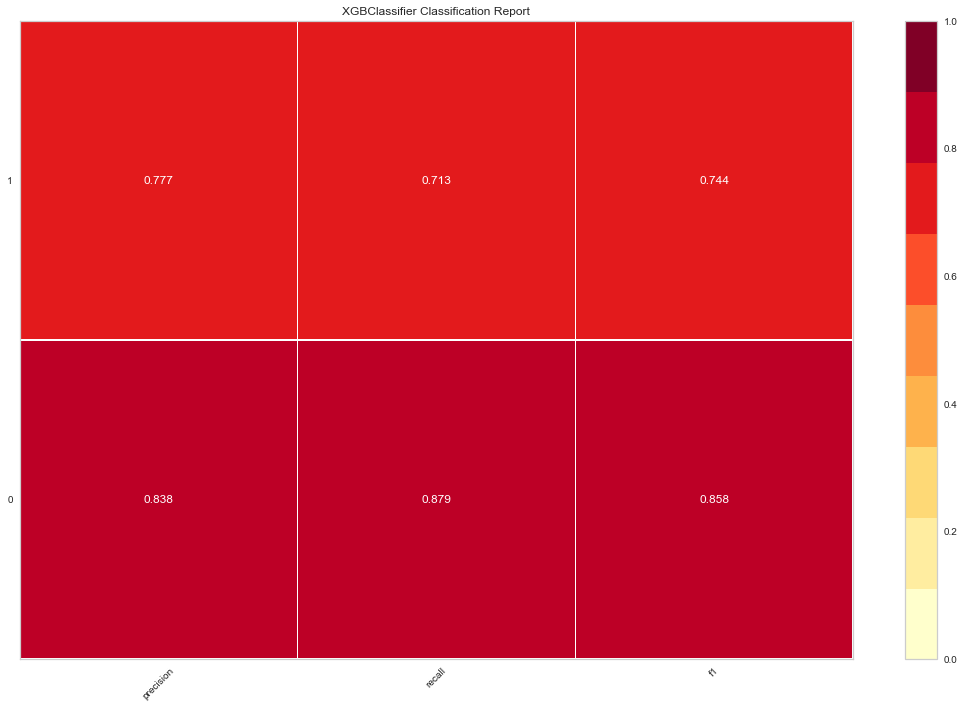

In [478]:
report = ClassificationReport(xgb_clf, size=(1080, 720), classes=['0','1'])

report.score(X_test, Y_test)
c = report.poof()


# Executive Summary <a id = "ps"></a>

### Problem Statement
* It costs the company R20 000 per case when a prediction of 0 is made when in fact it was a 1 in the original dataset, it also costs the company R1000 when a prediction of 1 is made when in fact it was a 0 in the original dataset.


### Success Evaluation <a id = "sm"></a>


Our model is doing relatively good, precision in predicting the negative class is 2% higher than the positve class, recall is 20% higher, and precision is 12% higher.

This poses a problem since we are losing 2000 for the False Negatives and a 1000 for False Positive.
and as shown in the confusion matrices above in the notebook, our model is better at classifying the positive class than it does the negative class, and we stand a chance of extracting more value from the model if we better classify the negative class.

Although the model can be of good business sense if there was slightly more value in the classifying the True positives and True Negatives. On top of this we can threshold our prediction probabilities at a much lower value to minimize the False negative and maximize the False postive, such that we lose more of the 1000's as opposed to the 2000's

The way the model is at this point as shown below: 

    - We stand a 70% chance of correclty classifying the negative class and 30% chance of incorrectly classifying the negative class (class_0 )
    - We also stand 88% chance of correctly classifying the postive class and 12% chance of incorrectly classifying postive class( class_1 )
    
There is more that could be done with more data, context and time.
Future work:
1. Model Expaliners continued
2. Bayesian optimization, more hyper parameter tuning
3. More data collection


Without feature_4
	Accuracy: 0.817
	Precision: 0.777
	Recall: 0.713
	F1: 0.744

Normalized confusion matrix


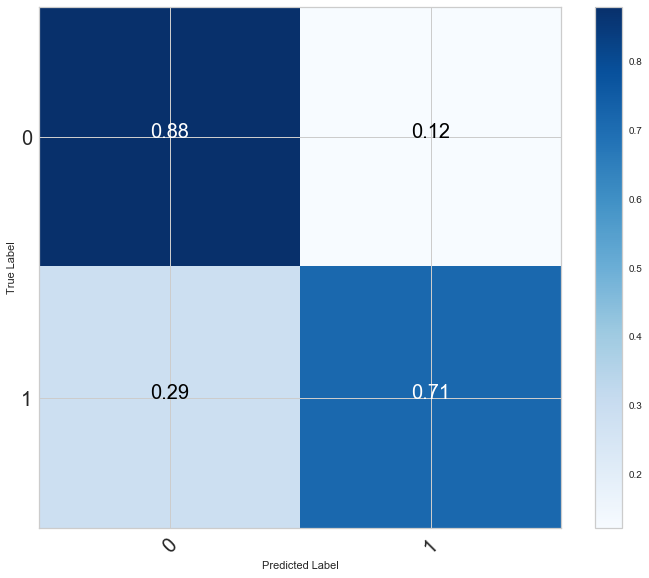

In [480]:

pred=xgb_clf.predict(X_test)
pred = (pred>= 0.5).astype('int')
cnf_matrix = confusion_matrix(Y_test, pred)
print("Without feature_4")
print("\tAccuracy: %1.3f"%xgb_clf.score(X_test, Y_test))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))
# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

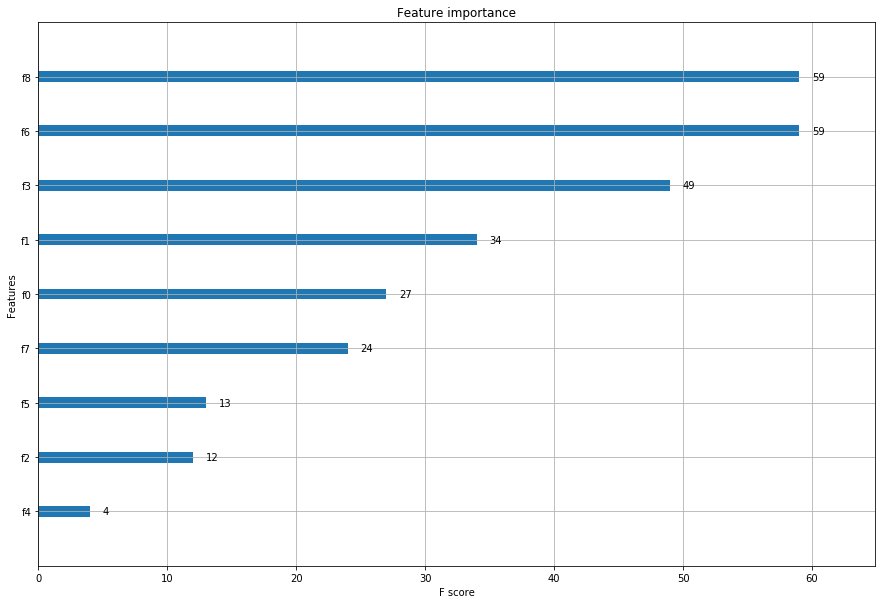

In [133]:
xgb.plot_importance(bst)

# Model Explainers <a id = "me"></a>


The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

SHAP summary plot:

- high number of __feature5__ reduce the predicted probability of belonging to class 1, low numbers of this feature increase
the probability. 

- All effects describe the behavior of the model and are not necessarily causal, just what the model can see form the given 
dataset

In [382]:
import shap


X= data[non_encode_features+encode]
y= dataset[response]



model = xgb_clf.fit(X, y)

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [390]:
features = non_encode_features + encode

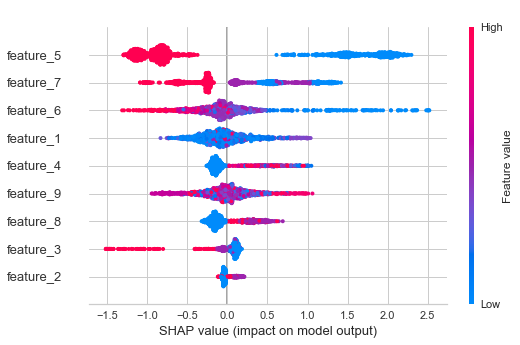

In [391]:
shap.summary_plot(shap_values, X, feature_names= features)

SHAP dependence plot focused on one feature:

1. 2D partial dependence plot    
    - The x-axis is __feature6__ . Each dot represents a single observation from the data set.
    - it seems high feature_6 values have low probability to belong to __class_1__  



2. 3D partial dependence plot 
    - We can go even steps further to plot, the dots being colored by magnitude of the feature it is strongly below correlated with 
    - For the plot below says feature_5 is high correlated with feature_7.
    low values of __feature_7__ (1-2)  that have the low(1-1.5) values of __feature_5(Blue)__ have a higher chance of being classified as __class_1__

We can even go further to check per prediction, what were the most influencial features.


###### All effects describe the behavior of the model and are not necessarily causality, just what the model can see form the given dataset

# 1. 2D

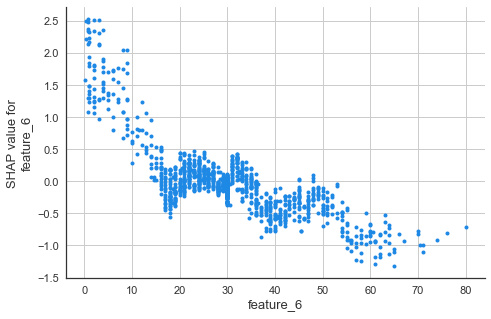

In [395]:
shap.dependence_plot("feature_6", shap_values, X, interaction_index=None)

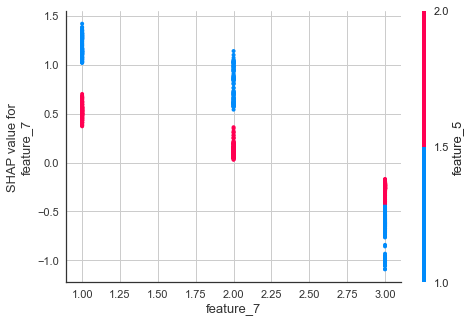

In [410]:
shap.dependence_plot('feature_7', shap_values, X,feature_names=features)

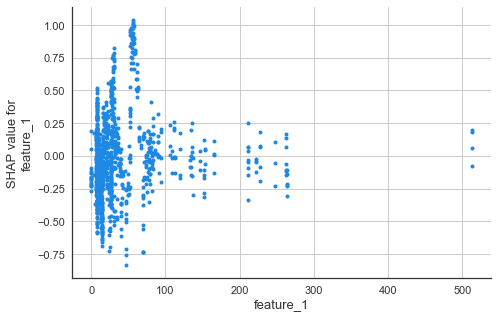

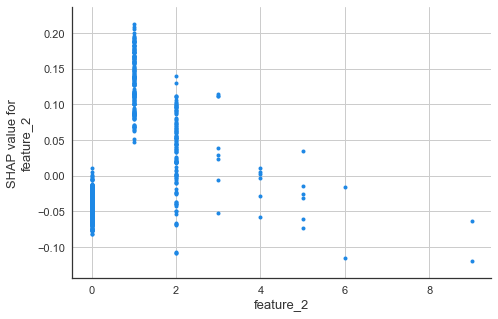

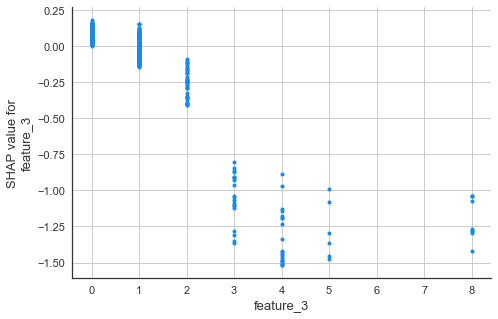

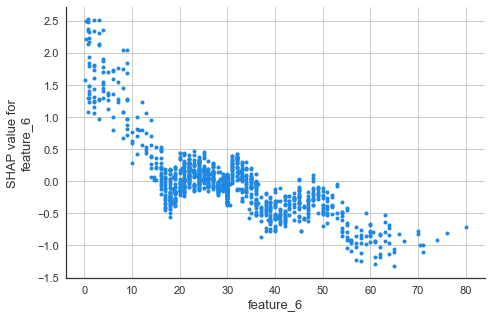

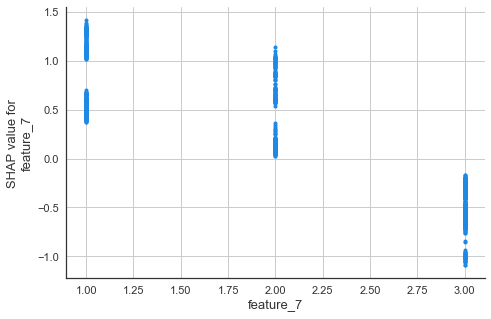

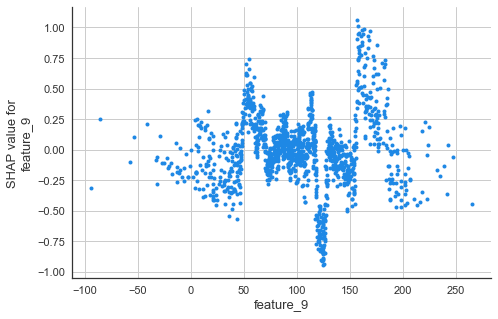

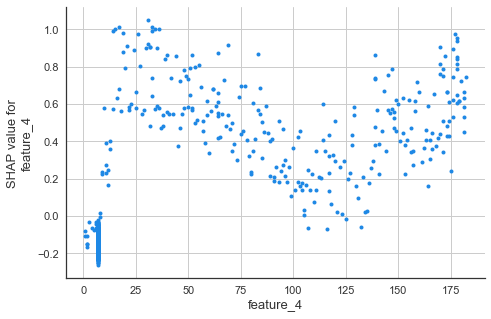

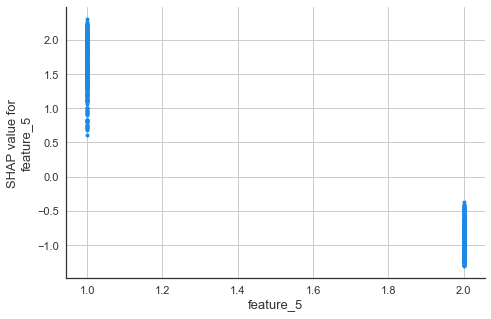

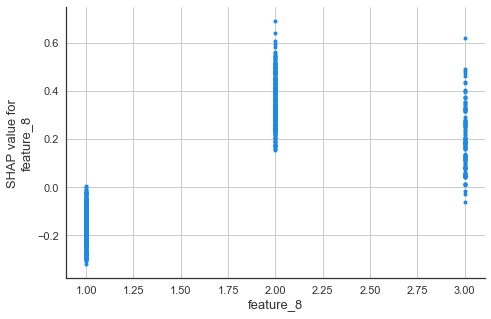

In [396]:
for feat in features:
    shap.dependence_plot(feat, shap_values, X, interaction_index=None)

# 2. 3D

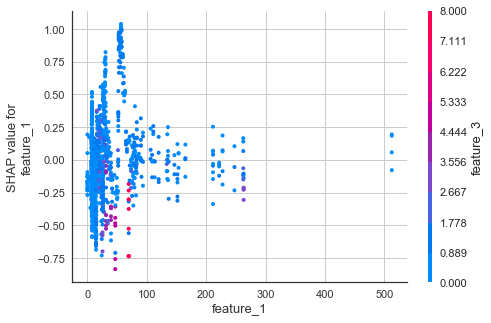

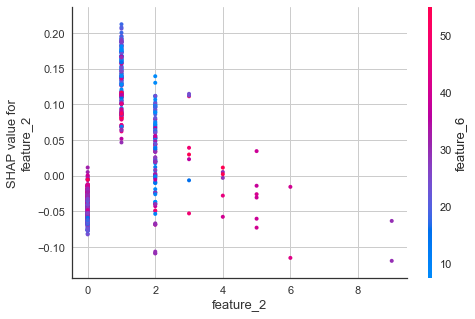

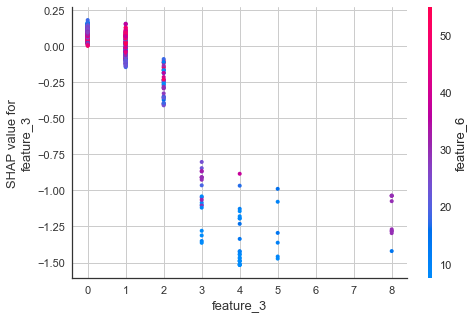

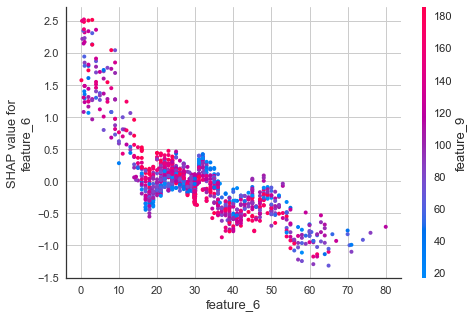

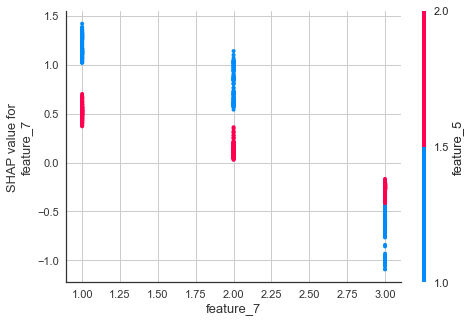

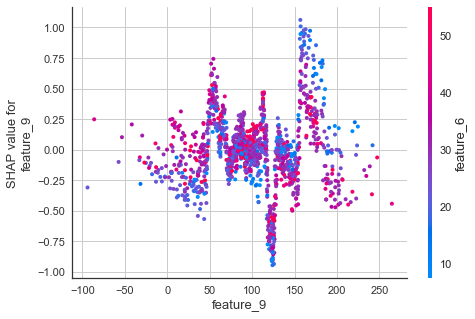

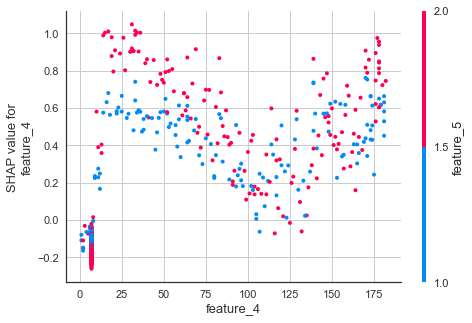

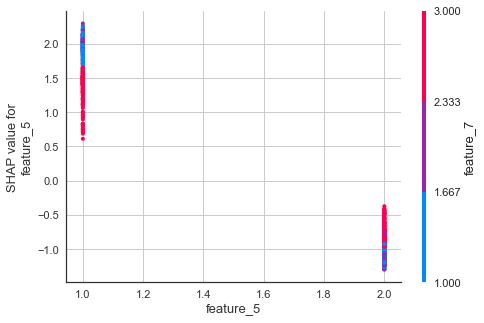

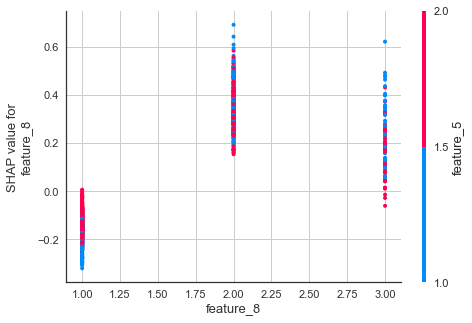

In [398]:
for feat in features:
    shap.dependence_plot(feat, shap_values, X,feature_names=features)

# Spark implementation of this model
   

In [1]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import VectorAssembler, StandardScaler

from pyspark.ml import PipelineModel, Pipeline, pipeline

from pyspark.ml.classification import GBTClassifier

from pyspark.sql import SparkSession, HiveContext
from pyspark.sql import SQLContext

import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt

pd.set_option('max_colwidth', -1) # to prevent truncating of columns in jupyter
pd.set_option('display.max_columns', None)

from pyspark.sql.functions import avg as avg, mean as mean, col as col

from pyspark.sql.types import *

from pyspark.sql.functions import isnan, when, count, col

# Launch spark session:

This session automatically reads the default spark_config file in this folder named "default_spark.conf":
    
eg spark default for this light_job is:
    
    - spark.executor.memory=1g
    - spark.executor.cores=1
    
A spark configuration with an assumption of a 100mil records would look like this depending on the width of dataset as well:
  
    -spark.executor.memory=25g
    -spark.executor.instances=15
    -spark.sql.shuffle.partitions= 40
    -spark.dynamicAllocation.enabled=False # We set this to true if we are unsure how to gauge reource intensity
    -spark.shuffle.service.enabled=true
    -spark.executor.cores=20
    -spark.speculation = true
    -#spark.storage.memoryFraction = 0.5
    -spark.cleaner.periodicGC.interval = 3s
    -spark.executor.heartbeatInterval = 50s
    -spark.locality.wait = 1s
    -spark.driver.memoryOverhead=8g
    -spark.yarn.executor.memoryOverhead=8g


In [2]:
spark = SparkSession.builder.appName('assignment').getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
sqlContext = SQLContext(spark)
spark.sparkContext.getConf().getAll()
hive_context = HiveContext(spark)

We the sparkUI to minitor our spark sessions as seen below

In [3]:
import os
from IPython.core.display import HTML
HTML('<a href="http://spark-{}.{}">Spark UI</a>'.format(os.getenv("CDSW_ENGINE_ID"),os.getenv("CDSW_DOMAIN")))

In [6]:
data = spark.read.csv('/user/tumisang2/assign.csv').persist()

In [7]:
data

_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9
1,211.3375,0,0,bigollo-16,blue,29.0,1,sigma,112.87794148245936
1,151.55,2,1,cantor-33,pink,0.9167,1,sigma,60.291423340617406
0,151.55,2,1,cantor-33,blue,2.0,1,sigma,143.79410265574725
0,151.55,2,1,cantor-33,pink,30.0,1,sigma,131.27835242517
0,151.55,2,1,cantor-33,blue,25.0,1,sigma,204.41571605575584
1,26.55,0,0,euler-23,pink,48.0,1,sigma,75.97058173624448
1,77.9583,0,1,descrates-18,blue,63.0,1,sigma,125.8535205910631
0,0.0,0,0,allen-47,pink,39.0,1,sigma,103.63740081236631
1,51.4792,0,2,cantor-112,blue,53.0,1,sigma,94.42563651108387
0,49.5042,0,0,null,pink,71.0,1,gamma,85.68763645367592


In [8]:
data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)



# Fill in missing values

In [9]:
dataset = data.fillna({'_c1': data.select(avg(data['_c0'])).collect()[0][0] ,
                          '_c6':data.select(avg(data['_c6'])).collect()[0][0] ,
                          '_c4':'Unknown',
                          '_c8':'gamma'} )

In [10]:
dataset.show(10)

+---+--------+---+---+------------+----+------+---+-----+------------------+
|_c0|     _c1|_c2|_c3|         _c4| _c5|   _c6|_c7|  _c8|               _c9|
+---+--------+---+---+------------+----+------+---+-----+------------------+
|  1|211.3375|  0|  0|  bigollo-16|blue|  29.0|  1|sigma|112.87794148245936|
|  1|  151.55|  2|  1|   cantor-33|pink|0.9167|  1|sigma|60.291423340617406|
|  0|  151.55|  2|  1|   cantor-33|blue|   2.0|  1|sigma|143.79410265574725|
|  0|  151.55|  2|  1|   cantor-33|pink|  30.0|  1|sigma|   131.27835242517|
|  0|  151.55|  2|  1|   cantor-33|blue|  25.0|  1|sigma|204.41571605575584|
|  1|   26.55|  0|  0|    euler-23|pink|  48.0|  1|sigma| 75.97058173624448|
|  1| 77.9583|  0|  1|descrates-18|blue|  63.0|  1|sigma| 125.8535205910631|
|  0|     0.0|  0|  0|    allen-47|pink|  39.0|  1|sigma|103.63740081236631|
|  1| 51.4792|  0|  2|  cantor-112|blue|  53.0|  1|sigma| 94.42563651108387|
|  0| 49.5042|  0|  0|     Unknown|pink|  71.0|  1|gamma| 85.68763645367592|

In [11]:
categorical_cols=['_c4','_c5','_c8']

numeric_cols =   ['_c1','_c2','_c3','_c6','_c7','_c9',]

response_variable = ['_c0']

In [12]:
dataset_train = dataset.select(*(col(c).cast("string").alias(c) for c in categorical_cols),
                               *(col(c).cast("float").alias(c) for c in numeric_cols), 
                               *(col(c).cast("float").alias(c) for c in response_variable))

In [13]:
dataset_train.printSchema()

root
 |-- _c4: string (nullable = false)
 |-- _c5: string (nullable = true)
 |-- _c8: string (nullable = false)
 |-- _c1: float (nullable = true)
 |-- _c2: float (nullable = true)
 |-- _c3: float (nullable = true)
 |-- _c6: float (nullable = true)
 |-- _c7: float (nullable = true)
 |-- _c9: float (nullable = true)
 |-- _c0: float (nullable = true)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


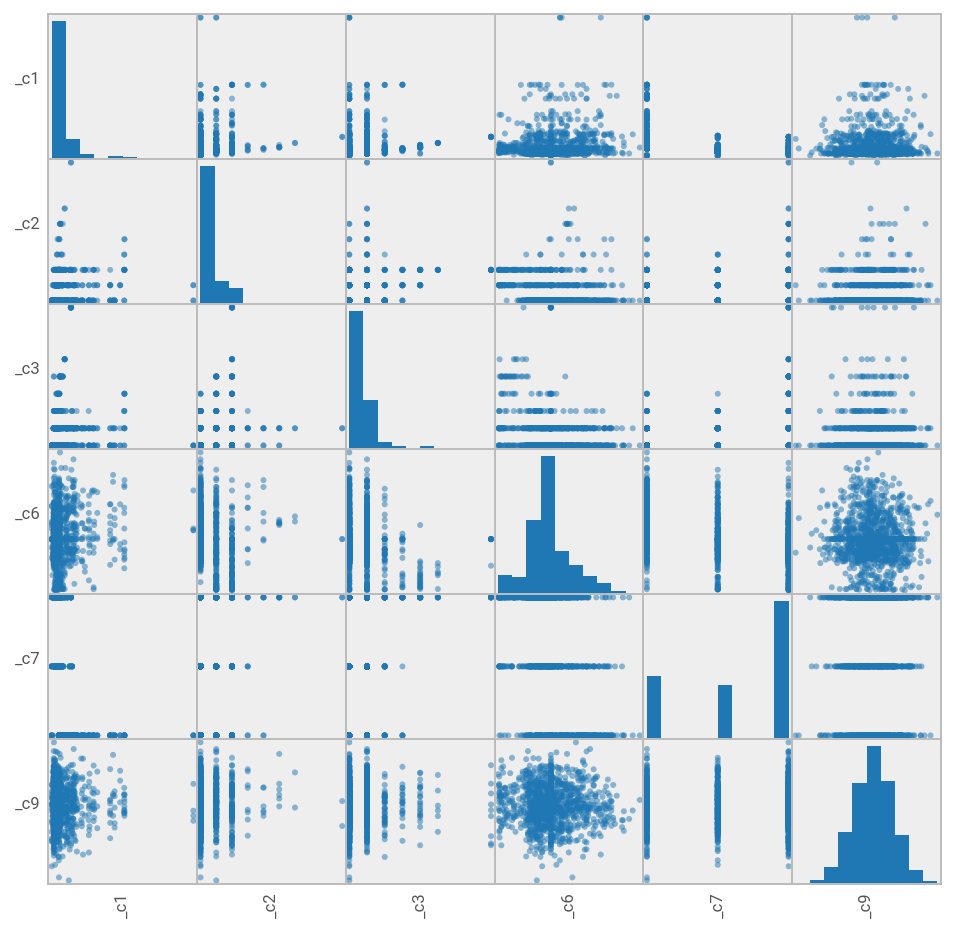

In [22]:
numeric_data = dataset_train.select(numeric_cols).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

#### There does not seem to be any highly correlated features

# Pipeline design <a id = "sl"></a>

    - Stage features
    - Index and Onehot Encode features
    - Assemble our features as vectors
    - Scale our features
    - Grid search for good parameter congiuration
    
This pipeline will be ready to consume data from a database and do predictions, we can go on to write the model object and have it run on our the server to make predictions as soon as the data is available as is when training the model. We can go on to evlauate the model looking at the ROC-AUC curves, assess good fit and all.

In [23]:
# Stage and index the neccessary column which are the categorical columns above
stages_ind=[]
stages_vec=[]
for categorical_col in categorical_cols:
    stages_ind = stages_ind + [StringIndexer(inputCol=categorical_col, outputCol=categorical_col + "_index", handleInvalid="skip")]
    stages_vec = stages_vec + [OneHotEncoder(inputCol=categorical_col + "_index", outputCol=categorical_col + "_vector" ) ]

In [24]:
assembler_ind = VectorAssembler(inputCols=[c + "_index" for c in categorical_cols] + numeric_cols
                                ,outputCol='features')
assembler_vec = VectorAssembler(inputCols=[c + "_vector" for c in categorical_cols] + numeric_cols
                                ,outputCol='features')

In [25]:
# data scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

In [26]:
# gbt = GBTClassifier(featuresCol='scaledFeatures',labelCol=response_variable,maxIter=200)
gbt = GBTClassifier(featuresCol='scaledFeatures',labelCol='_c0',maxIter=300)

In [45]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth,[4, 7, 9])
             .addGrid(gbt.maxBins, [300,350,400 ])
             .addGrid(gbt.maxIter, [150, 200,250])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [27]:
pipeline_gbt = Pipeline(stages= stages_ind + [assembler_ind,scaler,gbt])

In [28]:
train, test= dataset_train.randomSplit([0.9,0.1])

In [29]:
fit_model_gbt = pipeline_gbt.fit(train)

In [30]:
results_gbt = fit_model_gbt.transform(test)

In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [32]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="_c0", predictionCol='prediction', metricName='accuracy')
evaluator = BinaryClassificationEvaluator(labelCol="_c0", rawPredictionCol='prediction')

In [33]:
roc_gbt = evaluator.evaluate(results_gbt)
acc_gbt= acc_evaluator.evaluate(results_gbt)
print("accuracy",acc_gbt)
print("AUC-ROC" ,roc_gbt)

accuracy 0.7459016393442623
AUC-ROC 0.7266666666666667


In [34]:
y_true = results_gbt.select('_c0')
y_true = y_true.toPandas()

y_pred = results_gbt.select("prediction")
y_pred = y_pred.toPandas()

Normalized confusion matrix
[[ 0.83333333  0.16666667]
 [ 0.38        0.62      ]]


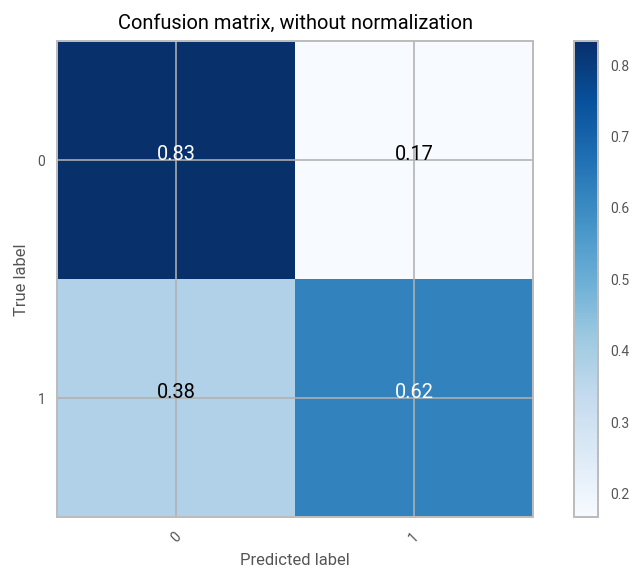

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1])
cnf_matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization',normalize=True)
plt.show()

In [47]:
results_gbt

_c4,_c5,_c8,_c1,_c2,_c3,_c6,_c7,_c9,_c0,_c4_index,_c5_index,_c8_index,features,scaledFeatures,rawPrediction,probability,prediction
bigollo-16,blue,sigma,211.3375,0.0,0.0,29.0,1.0,112.877945,1.0,29.0,1.0,0.0,"[29.0,1.0,0.0,211...",[0.41363302134060...,[-2.7841050626117...,[0.00380279040501...,1.0
cantor-33,pink,sigma,151.55,2.0,1.0,0.9167,1.0,60.291424,1.0,7.0,0.0,0.0,"[7.0,0.0,0.0,151....",[-0.2075982210380...,[-2.3443501492456...,[0.00911479025034...,1.0
cantor-33,blue,sigma,151.55,2.0,1.0,2.0,1.0,143.7941,0.0,7.0,1.0,0.0,"[7.0,1.0,0.0,151....",[-0.2075982210380...,[1.72377766806525...,[0.96915815185287...,0.0
cantor-33,pink,sigma,151.55,2.0,1.0,30.0,1.0,131.27835,0.0,7.0,0.0,0.0,"[7.0,0.0,0.0,151....",[-0.2075982210380...,[1.77363941190550...,[0.97200347063465...,0.0
cantor-33,blue,sigma,151.55,2.0,1.0,25.0,1.0,204.41571,0.0,7.0,1.0,0.0,"[7.0,1.0,0.0,151....",[-0.2075982210380...,[1.30525754983663...,[0.93153525525744...,0.0
euler-23,pink,sigma,26.55,0.0,0.0,48.0,1.0,75.97058,1.0,158.0,0.0,0.0,"[158.0,0.0,0.0,26...",[4.05630712437888...,[-0.8141835990002...,[0.16405416152068...,1.0
descrates-18,blue,sigma,77.9583,0.0,1.0,63.0,1.0,125.85352,1.0,166.0,1.0,0.0,"[166.0,1.0,0.0,77...",[4.28220939433474...,[-2.2587801033868...,[0.01079775880495...,1.0
cantor-112,blue,sigma,51.4792,0.0,2.0,53.0,1.0,94.42564,1.0,26.0,1.0,0.0,"[26.0,1.0,0.0,51....",[0.32891967010715...,[-2.6353742416797...,[0.00511348003562...,1.0
Unknown,pink,gamma,49.5042,0.0,0.0,71.0,1.0,85.68764,0.0,0.0,0.0,1.0,"[0.0,0.0,1.0,49.5...",[-0.4052627072493...,[1.94814719618135...,[0.98008750418043...,0.0
cantor-73,pink,gamma,227.525,0.0,1.0,47.0,1.0,125.17226,0.0,61.0,0.0,1.0,"[61.0,0.0,1.0,227...",[1.31724210116405...,[1.82004114341920...,[0.97442126272352...,0.0


# We can then use the model on the whole dataset

This will also look at the seen data so this is not the best or true representation of the model. There is a lot we can do here given more data and a bit more time and context.

In [39]:
results_gbt = fit_model_gbt.transform(dataset_train)

In [40]:
roc_gbt = evaluator.evaluate(results_gbt)
acc_gbt= acc_evaluator.evaluate(results_gbt)
print("accuracy",acc_gbt)
print("AUC-ROC" ,roc_gbt)

accuracy 0.9645061728395061
AUC-ROC 0.9587177897812804


In [41]:
y_true = results_gbt.select('_c0')
y_true = y_true.toPandas()

y_pred = results_gbt.select("prediction")
y_pred = y_pred.toPandas()

Normalized confusion matrix
[[ 0.9826087   0.0173913 ]
 [ 0.06517312  0.93482688]]


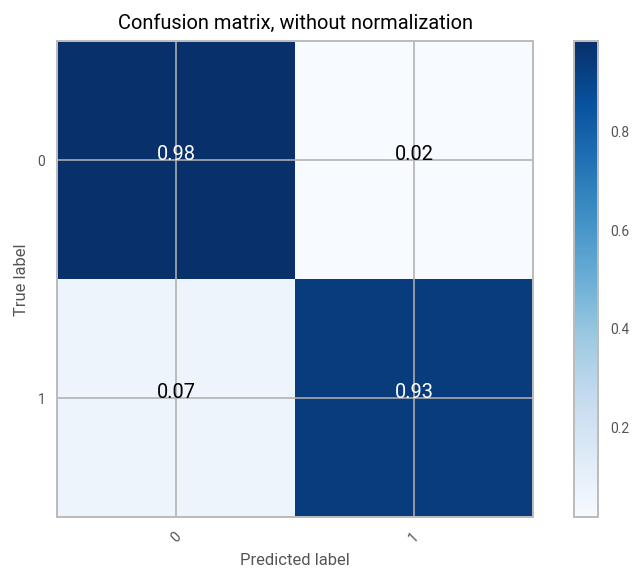

In [42]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1])
cnf_matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization',normalize=True)
plt.show()